In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, acf, q_stat

In [2]:
us_cpi_df = pd.read_excel(r"../data/raw/revised-seasonally-adjusted-indexes-2021.xlsx")
us_cpi_df.head()

/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,ITEM,TITLE,seriesid,DATA_TYPE,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2017,243.618,244.006,243.892,244.193,244.004,244.163,244.243,245.183,246.435,246.626,247.284,247.805
1,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2018,248.743,249.439,249.581,250.146,250.779,251.118,251.323,251.749,252.239,252.862,252.657,252.551
2,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2019,252.470,253.135,254.273,255.163,255.325,255.361,255.900,256.179,256.596,257.305,257.788,258.263
3,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2020,258.682,259.007,258.165,256.094,255.944,257.217,258.543,259.580,260.190,260.352,260.721,261.564
4,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2021,262.200,263.346,265.028,266.727,268.599,270.955,272.184,273.092,274.214,276.590,278.524,280.126


In [7]:
all_items_df = us_cpi_df[(us_cpi_df['TITLE'] == 'All items') & (us_cpi_df['DATA_TYPE'] == 'SEASONALLY ADJUSTED INDEX')].drop_duplicates('YEAR')
all_items_df

,ITEM,TITLE,seriesid,DATA_TYPE,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2017,243.618,244.006,243.892,244.193,244.004,244.163,244.243,245.183,246.435,246.626,247.284,247.805
1,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2018,248.743,249.439,249.581,250.146,250.779,251.118,251.323,251.749,252.239,252.862,252.657,252.551
2,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2019,252.470,253.135,254.273,255.163,255.325,255.361,255.900,256.179,256.596,257.305,257.788,258.263
3,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2020,258.682,259.007,258.165,256.094,255.944,257.217,258.543,259.580,260.190,260.352,260.721,261.564
4,SA0,All items,CUSR0000SA0,SEASONALLY ADJUSTED INDEX,2021,262.200,263.346,265.028,266.727,268.599,270.955,272.184,273.092,274.214,276.590,278.524,280.126


In [10]:
df_long = all_items_df.melt(id_vars=["ITEM", "TITLE", "seriesid", "DATA_TYPE", "YEAR"],
                  var_name="Month", value_name="CPI VALUE")

# Convert month abbreviations to numbers
month_map = {"JAN": "01", "FEB": "02", "MAR": "03", "APR": "04",
             "MAY": "05", "JUN": "06", "JUL": "07", "AUG": "08",
             "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12"}

df_long["Month"] = df_long["Month"].map(month_map)

# Create Year-Month column
df_long["Date"] = pd.to_datetime(df_long["YEAR"].astype(str) + "-" + df_long["Month"])

# Set Date as index
df_long = df_long.set_index("Date").sort_index()

# Drop unnecessary columns if needed
df_long = df_long[["CPI VALUE"]]
difference = df_long['CPI VALUE'].iloc[-1] - df_long['CPI VALUE'].iloc[0]
perc_change = (difference / df_long['CPI VALUE'].iloc[0])
print(f"The Inflation from the beginning of 2018 to the end of 2019 was: {perc_change:.2%}")

The Inflation from the beginning of 2018 to the end of 2019 was: 14.99%


In [9]:
us_tariff_timeline = {'US Tariffs on Solar/Washing Machines': ['2018-01-22', '$10.3 Billion'],
                 'Chinese Response to Solar/Washing Machine Tariffs with Sorghum Tariffs': ['2018-04-17', "$1 Billion" ],
                 'Chinese Ends Sorghum Response': ["2018-05-18"],
                 'American Metal Tariffs Go into Effect /w exemptions': ['2018-03-23', "17.9 Billion"],
                 'Chinese Metal Tariff Retailation': ['2018-04-02', '$2.4 Billion'],
                 'US Exemptions removed for EU, Canada, Mexico': ['2018-06-01', "N/A"],
                 'EU Retaliates': ['2018-06-22', "$3.2 Billion"],
                 'Canada Strikes Back': ['2018-07-01', '$12.8 Billion'],
                 'Turkey Retailates': ['2018-09-01', '$1 Billion'],
                 'US Doubles Tariffs on Turkey': ['2018-08-14', 'N/A'],
                 'Turkey Retailates Again': ['2018-12-14', 'N/A'],
                 'US vs Canada/Mexico Trade War ends': ['2019-05-17', 'N/A'],
                 'US Starts Trade War with India': ['2019-05-05', 'N/A'],
                 'India Retaliates to Loosing Special Status': ['2019-06-16', 'N/A'],
                 'Tariffs Broadened, affects imports from China, EU, Taiwan, Japan': ['2020-01-24', 'N/A']
                 }

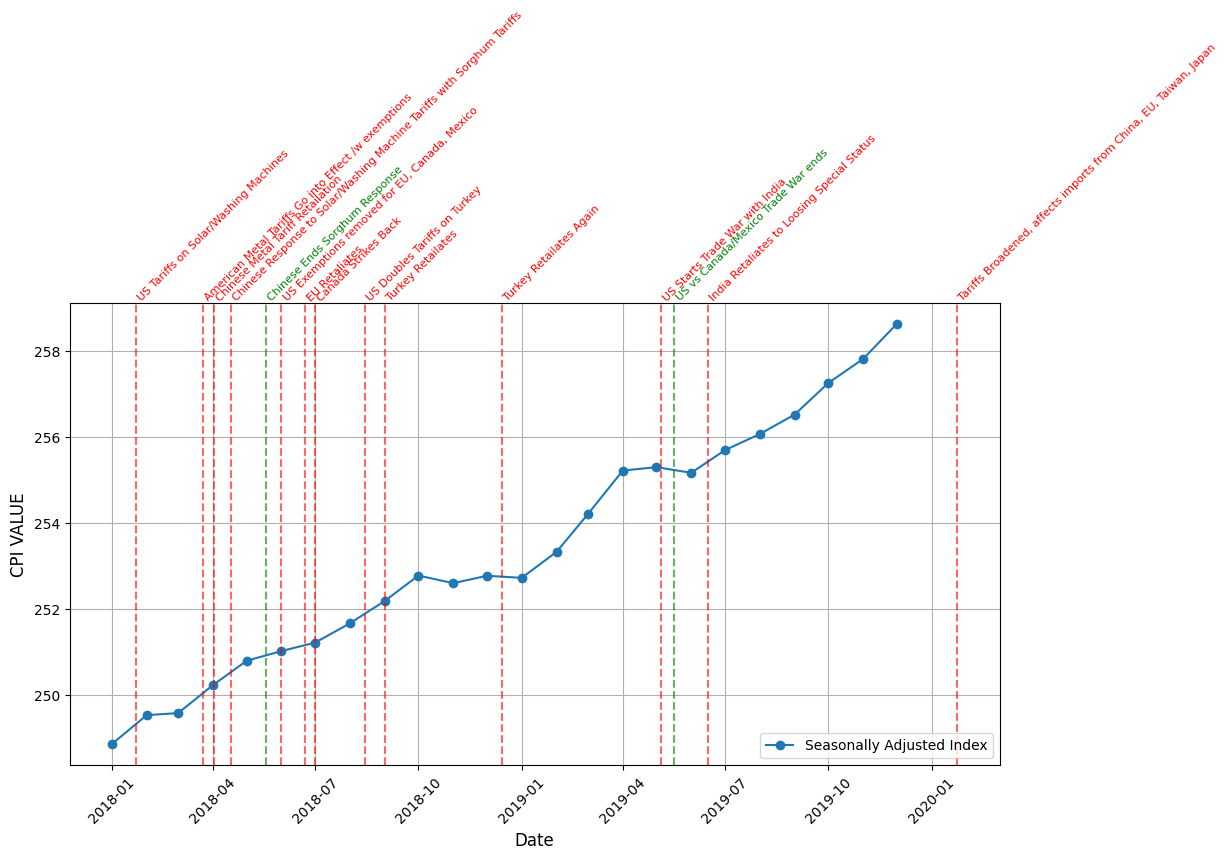

In [60]:
event_dates = {event: pd.to_datetime(date_info[0]) for event, date_info in us_tariff_timeline.items()}

# Extract y_max from the DataFrame
y_max = df_long['CPI VALUE'].max()

# Set label offset
label_offset = y_max + 0.5

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df_long.index, df_long["CPI VALUE"], marker='o', linestyle='-', label="Seasonally Adjusted Index")

# Add vertical lines for each event
for event, date in event_dates.items():
    color = 'green' if 'ends' in event.lower() else 'red'  # Green if 'ends' is in the event name
    plt.axvline(x=date, color=color, linestyle='--', alpha=0.6)
    plt.text(date, label_offset, event, rotation=45, verticalalignment='bottom', 
             fontsize=8, color=color)

# Formatting the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("CPI VALUE", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()